### Linear Quantisation

#### Installations

In [ ]:
#  !pip install accelerate==0.26.1 seaborn==0.13.1 torch==2.1.1 transformers==4.35.0

#### Helper functions

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch

def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=None):
    """
    Plot a heatmap of tensors using seaborn
    """
    sns.heatmap(tensor.cpu().numpy(), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt=".2f", cbar=False)
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])


def plot_quantization_errors(original_tensor, quantized_tensor, dequantized_tensor, dtype = torch.int8, n_bits = 8):
    """
    A method that plots 4 matrices, the original tensor, the quantized tensor
    the de-quantized tensor and the error tensor.
    """
    # Get a figure of 4 plots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the first matrix
    plot_matrix(original_tensor, axes[0], 'Original Tensor', cmap=ListedColormap(['white']))

    # Get the quantization range and plot the quantized tensor
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    plot_matrix(quantized_tensor, axes[1], f'{n_bits}-bit Linear Quantized Tensor', vmin=q_min, vmax=q_max, cmap='coolwarm')

    # Plot the de-quantized tensors
    plot_matrix(dequantized_tensor, axes[2], 'Dequantized Tensor', cmap='coolwarm')

    # Get the quantization errors
    q_error_tensor = abs(original_tensor - dequantized_tensor)
    plot_matrix(q_error_tensor, axes[3], 'Quantization Error Tensor', cmap=ListedColormap(['white']))

    fig.tight_layout()
    plt.show()


### Let us first understand the concept of Linear Quantisation

Quantisation is the process of converting a larger range of values into a smaller range of values. Here we will be discussing Linear Quantisation. 
Linear qunatisation maps floating point range [r_min, r_max] to quantised range [q_min, q_max].

In [4]:
# Imports
import torch

### Quantisation of a tensor

Quantisation of a tensor is done by the following formula:
```q = int(round(r/scale)) + zero_point```

where:
- q is the quantised value
- r is the real value
- scale is the scale factor
- zero_point is the zero point

In [5]:
def linear_q_with_scale_and_zero_point(tensor, scale,zero_point, dtype=torch.int8):
    scaled_and_shifted_tensor = tensor/scale + zero_point
    rounded = torch.round(scaled_and_shifted_tensor)

    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max

    q_tensor = rounded.clamp(q_min, q_max).to(dtype)
    return q_tensor

In [6]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [7]:
scale = 3.5
zero_point = -70

In [8]:
quantised_tensor = linear_q_with_scale_and_zero_point(test_tensor, scale=scale, zero_point=zero_point)

In [9]:
quantised_tensor

tensor([[ -15,  -74,  127],
        [ -44,   14, -123],
        [ -70,  126,    0]], dtype=torch.int8)

In [10]:
# dequantised_tensor = scale * (quantised_tensor.float() - zero_point) # using float is required, else have overflow errors
# dequantised_tensor

In [11]:
# dequantised_tensor = scale * (quantised_tensor - zero_point)
# dequantised_tensor

### De-quantisation of a tensor

De-quantisation of a tensor is done by the following formula:
```r = (q - zero_point) * scale```

where:
- r is the real value
- q is the quantised value
- scale is the scale factor
- zero_point is the zero point

Note, while dequantising from int8 to float32, the quantised value is first converted to int32 and then to float32 to avoid overflow.

In [12]:
def linear_dequantisation(quantised_tensor, scale, zero_point):
    dequantised_tensor = scale * (quantised_tensor.float() - zero_point)
    return dequantised_tensor

In [13]:
dequantised_tensor = linear_dequantisation(quantised_tensor, scale, zero_point)
dequantised_tensor

tensor([[ 192.5000,  -14.0000,  689.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000,  686.0000,  245.0000]])

### Plotting the quantised and de-quantised tensor

We will now plot the quantised and de-quantised tensor to understand the concept better.

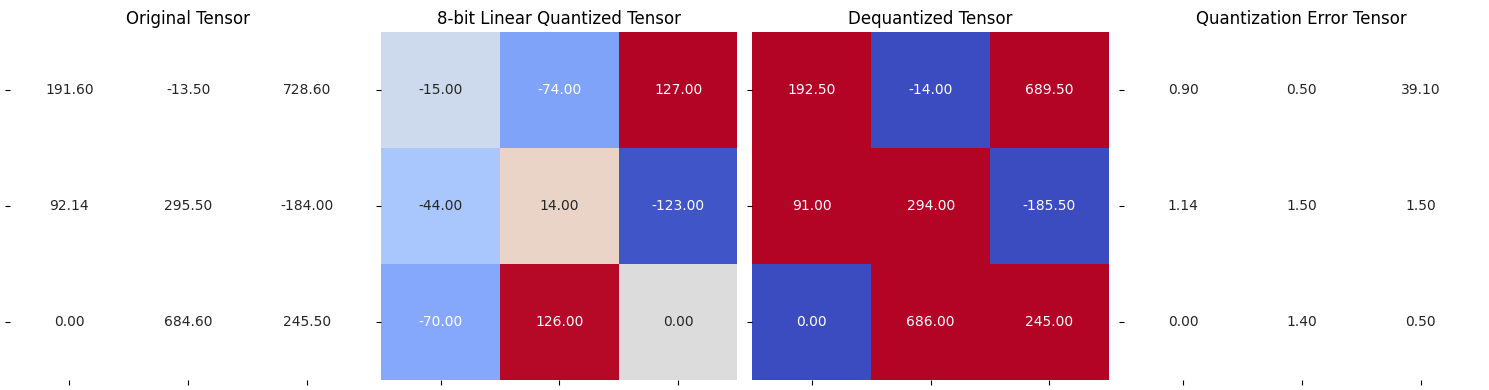

In [14]:
plot_quantization_errors(test_tensor, quantised_tensor, dequantised_tensor)

### Obatain scale and zero point

Scale of the quantised tensor is given by the formula:
```
r_min = s * (q_min - z)
r_max = s * (q_max - z)
```

For zero point, assuming the quantisation to integer is done by rounding, we have:
```z = int(round(q_min - r_min/s))```


In [15]:
def get_q_scale_and_zero_point(tensor, dtype=torch.int8):
    q_min, q_max = torch.iinfo(torch.int8).min, torch.iinfo(torch.int8).max
    r_min, r_max = test_tensor.min().item(), test_tensor.max().item()

    # Calculate scale and zero_point values
    scale = (r_max - r_min) / (q_max - q_min)
    zero_point = (scale * q_min - r_min) / scale

    # Handle edge cases or get final values
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        zero_point = int(round(zero_point))

    return scale, zero_point

In [16]:
new_scale, new_zero_point = get_q_scale_and_zero_point(test_tensor)

In [17]:
quantised_tensor = linear_q_with_scale_and_zero_point(test_tensor, new_scale, new_zero_point)

In [18]:
dequantised_tensor = linear_dequantisation(quantised_tensor, new_scale, new_zero_point)

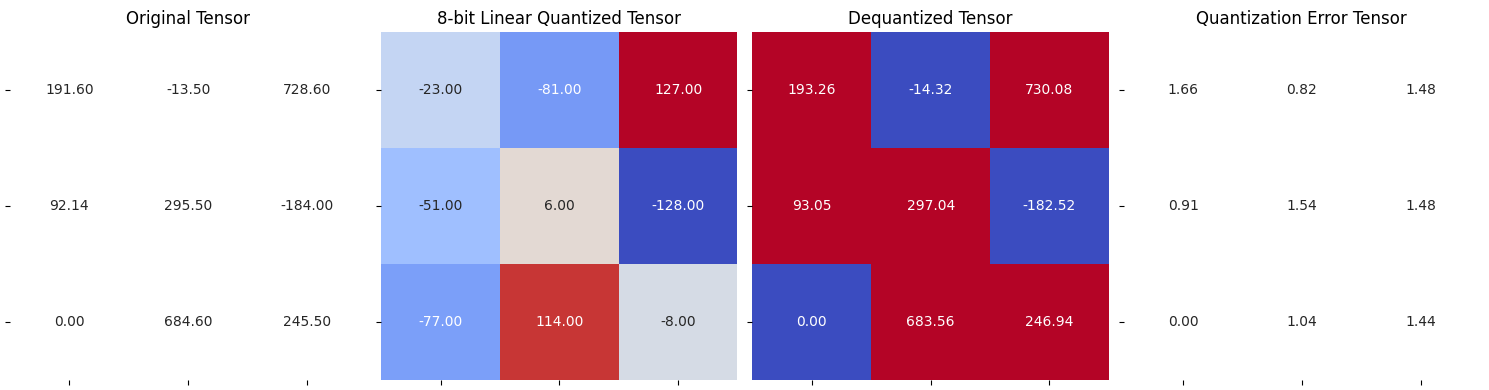

In [19]:
plot_quantization_errors(test_tensor, quantised_tensor, dequantised_tensor)

In [42]:
def linear_quantisation(tensor, dtype=torch.int8):
    scale, zero_point = get_q_scale_and_zero_point(tensor, dtype=dtype)
    quantised_tensor = linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype=dtype)
    return quantised_tensor, scale, zero_point

In [43]:
r_tensor = torch.randn((4,4))
r_tensor

tensor([[-1.2697,  0.2584,  0.5014, -0.5865],
        [ 0.5118, -0.5165, -0.3036,  0.2672],
        [-0.2539, -0.0685,  1.0072, -0.6747],
        [ 0.9120, -1.4255, -0.9519, -0.7222]])

In [44]:
quantised_tensor, scale, zero_point = linear_quantisation(r_tensor)
quantised_tensor

tensor([[-128,    0,   21,  -74],
        [  22,  -68,  -50,    0],
        [ -45,  -29,   65,  -82],
        [  57, -128, -106,  -86]], dtype=torch.int8)

In [45]:
scale, zero_point

(0.011447591875113693, -23)

In [46]:
dequantised_tensor = linear_dequantisation(quantised_tensor, scale, zero_point)
dequantised_tensor

tensor([[-1.2020,  0.2633,  0.5037, -0.5838],
        [ 0.5151, -0.5151, -0.3091,  0.2633],
        [-0.2518, -0.0687,  1.0074, -0.6754],
        [ 0.9158, -1.2020, -0.9502, -0.7212]])

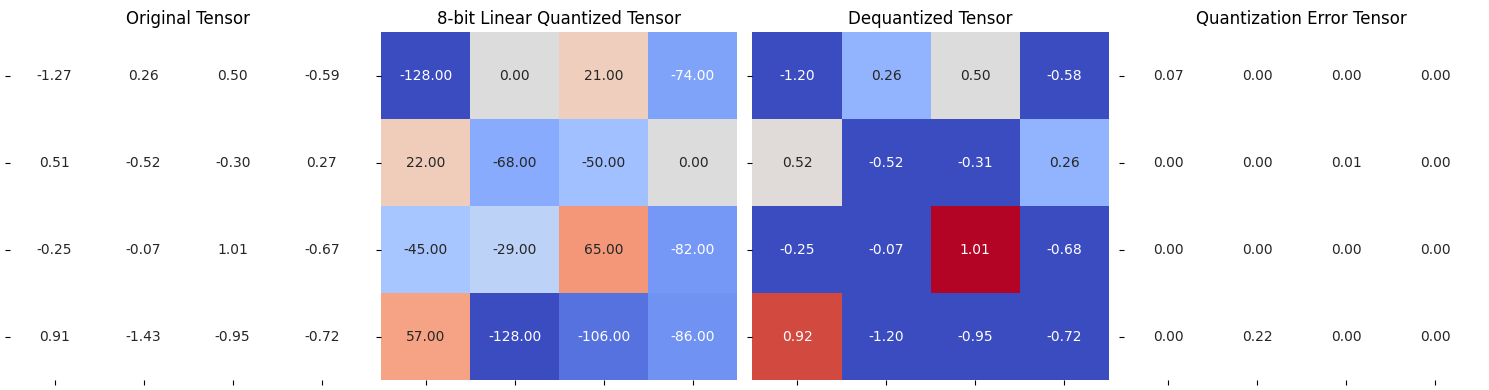

In [47]:
plot_quantization_errors(r_tensor, quantised_tensor, dequantised_tensor)

In [48]:
print(f"Quantisation error :{(dequantised_tensor-r_tensor).square().mean()}")

Quantisation error :0.0034151196014136076


### Per channel quantisation

In [49]:
def get_q_scale_symmetric(tensor, dtype=torch.int8):
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max

    # return the scale
    return r_max/q_max

In [50]:
def linear_q_symmetric_per_channel(tensor, dim, dtype= torch.int8):
    
    return quantised_tensor, scale

In [51]:
test_tensor = torch.randn((4,4))
test_tensor

tensor([[ 0.4226, -1.0351, -1.0784, -0.3172],
        [ 1.6449, -0.7154, -0.6831,  0.2622],
        [-1.3536, -0.6600,  1.0408,  0.4761],
        [ 0.8275, -0.0059,  0.4547,  1.0525]])

In [52]:
def linear_q_symmetric_per_channel(r_tensor, dim, dtype=torch.int8):
    
    output_dim = r_tensor.shape[dim]
    # store the scales
    scale = torch.zeros(output_dim)

    for index in range(output_dim):
        sub_tensor = r_tensor.select(dim, index)
        scale[index] = get_q_scale_symmetric(sub_tensor, dtype=dtype)

    # reshape the scale
    scale_shape = [1] * r_tensor.dim()
    scale_shape[dim] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_q_with_scale_and_zero_point(
        r_tensor, scale=scale, zero_point=0, dtype=dtype)
   
    return quantized_tensor, scale

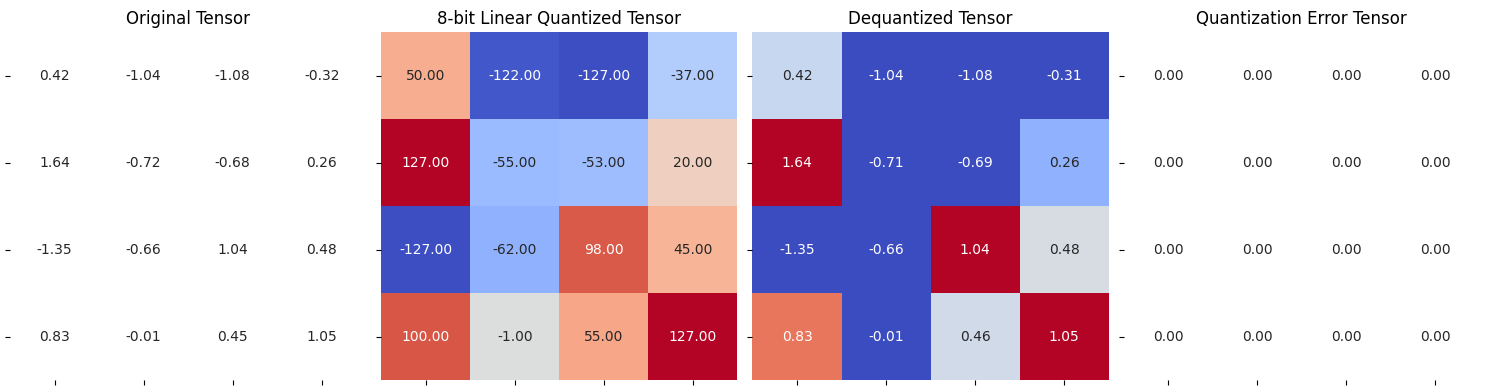

Quantisation error :4.959743364452152e-06


In [71]:
### along the rows (dim = 0)
quantised_tensor_0, scale_0 = linear_q_symmetric_per_channel(
    test_tensor, dim=0)
dequantised_tensor_0 = linear_dequantisation(
    quantised_tensor_0, scale_0, 0)

plot_quantization_errors(
    test_tensor, quantised_tensor_0, dequantised_tensor_0)


print(f"Quantisation error :{(dequantised_tensor_0-test_tensor).square().mean()}")


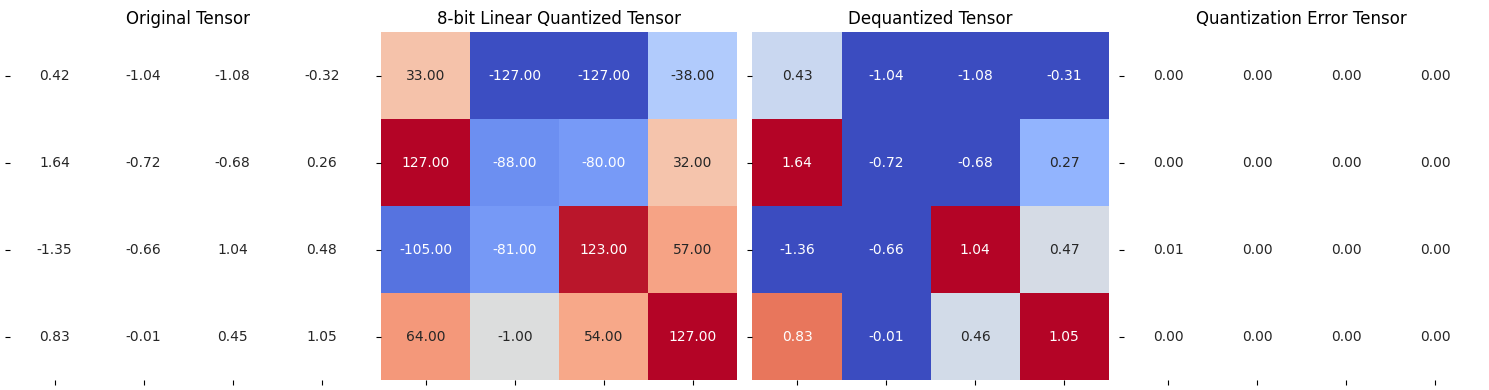

Quantisation error :9.084343219001312e-06


In [68]:
### along the columns (dim = 1)
quantised_tensor_1, scale_1 = linear_q_symmetric_per_channel(
    test_tensor, dim=1)
    
dequantised_tensor_1 = linear_dequantisation(
    quantised_tensor_1, scale_1, 0)

plot_quantization_errors(
    test_tensor, quantised_tensor_1, dequantised_tensor_1, n_bits=8)

print(f"Quantisation error :{(dequantised_tensor_1-test_tensor).square().mean()}")

*Huge credits to HuggingFace team for making the Quantisation course available for free on deeplearning.ai*